## This is the same model as the one in ASR-Dysarthria-Words just trained with data from participants with very low speech intelligibility

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from sklearn.metrics import classification_report
#from sklearn.matrics import classification_report

# Set seed for experiment reproducibility
seed = 54198
tf.random.set_seed(seed)
np.random.seed(seed)


In [2]:
myPath = pathlib.Path('data/VeryLow')
words = np.array(tf.io.gfile.listdir(str(myPath)))
words = words[words != 'index']
word_names = tf.io.gfile.glob(str(myPath)+ '/*/*')
word_names = tf.random.shuffle(word_names)
numWords = len(word_names)
print('Total number of Spoken words:', numWords)
print('Total number of Samples per Folder:',len(tf.io.gfile.listdir(str(myPath/words[0]))))
print('words:', words, 'Word count:', len(words))

Total number of Spoken words: 975
Total number of Samples per Folder: 65
words: ['come' 'eight' 'five' 'four' 'Go' 'left' 'nine' 'No' 'one' 'right'
 'seven' 'six' 'three' 'two' 'Zero'] Word count: 15


In [3]:
Training_set = word_names[:int(numWords*0.8)]
validation_set = word_names[int(numWords*0.8): int(numWords*0.8) + int(numWords*0.1)]
test_set = word_names[-int(numWords*0.1):]

print('Training set size', len(Training_set))
print('Validation set size', len(validation_set))
print('Test set size', len(test_set))


Training set size 780
Validation set size 97
Test set size 97


In [4]:
test_file = tf.io.read_file('data/VeryLow/seven/F03_B2_D7_M3.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1) 
    return tf.squeeze(audio, axis=-1)
def filesNames(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]
def get_waveform_and_label(file_path):
  label = filesNames(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(Training_set)
waveform_ds = files_ds.map(map_func =get_waveform_and_label, num_parallel_calls=AUTOTUNE)

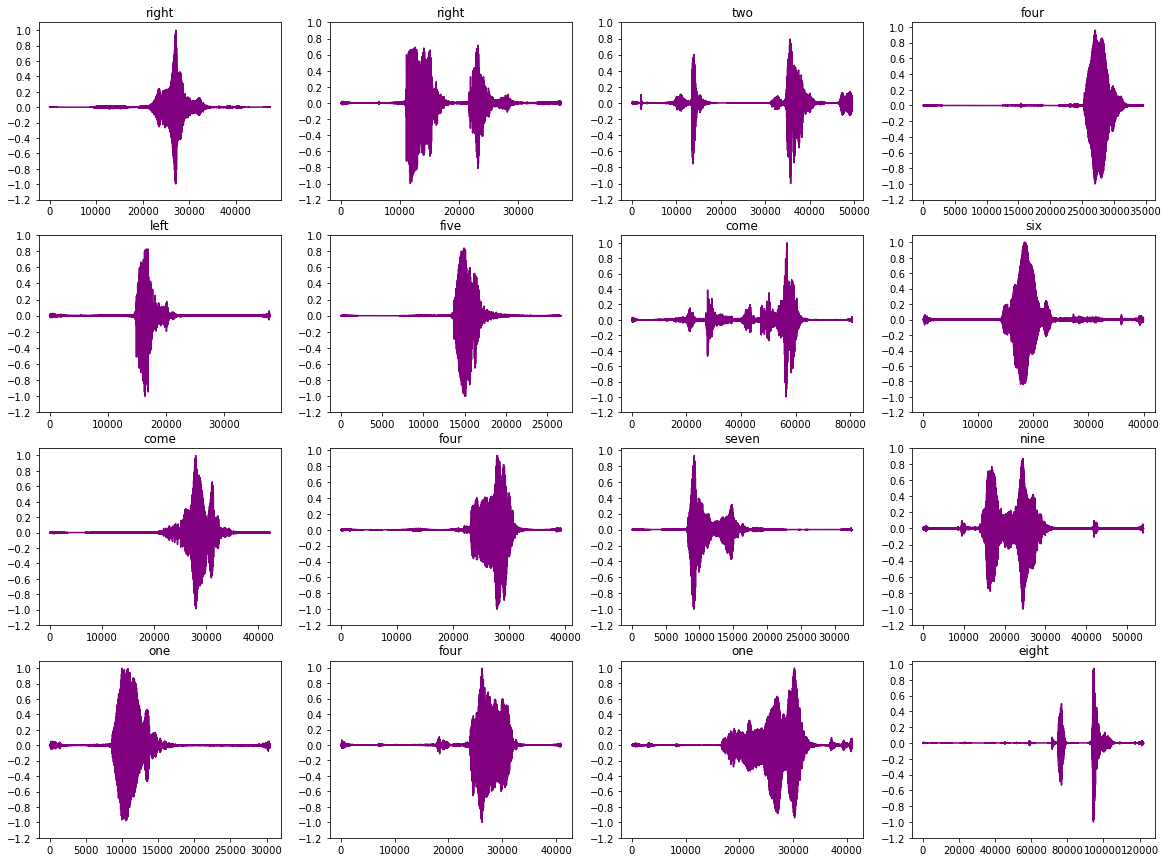

In [5]:
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

for i, (audio, label) in enumerate(waveform_ds.take(16)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy(), color = 'purple')
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()



In [6]:
def get_spectrogram(waveform):
    waveform = waveform[:160000]
    zero_padding = tf.zeros([160000] - tf.shape(waveform),dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=564, frame_step=288)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('WORD:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

print('Audio playback')
display.display(display.Audio(waveform, rate=16000))



WORD: right
Waveform shape: (47363,)
Spectrogram shape: (554, 513, 1)
Audio playback


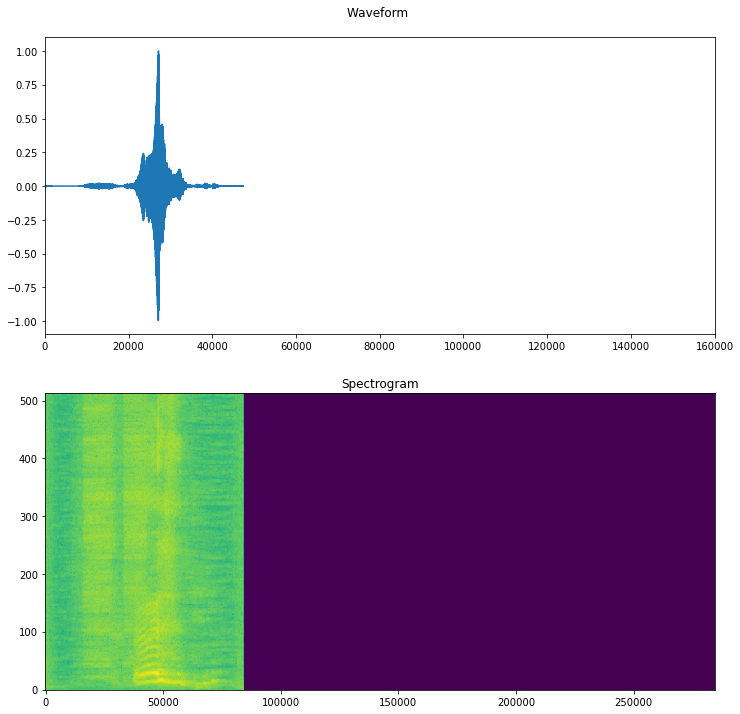

In [7]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, shading='auto')
fig, axes = plt.subplots(2, figsize=(12, 12))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform \n')
axes[0].set_xlim([0, 160000])

plot_spectrogram(spectrogram.numpy(), axes[1])

axes[1].set_title('Spectrogram')
plt.show()



tf.Tensor([47363], shape=(1,), dtype=int32)


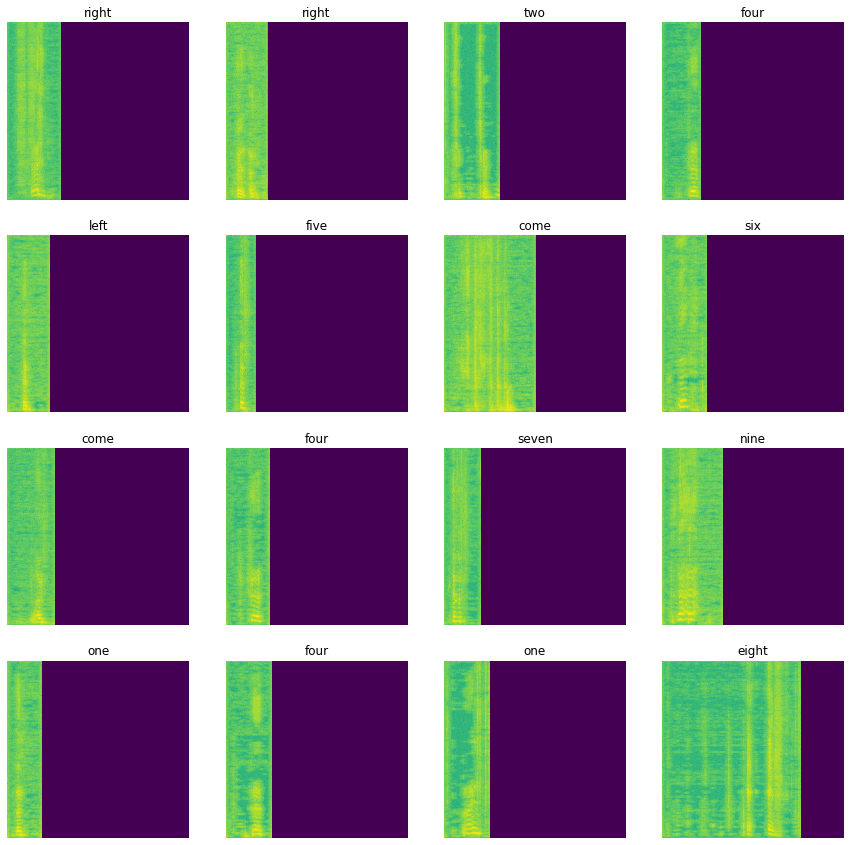

In [8]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == words)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)
print(tf.shape(waveform))
rows = 4
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(words[label_id.numpy()])
  ax.axis('off')

plt.show()




In [9]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = spectrogram_ds
test_ds = preprocess_dataset(test_set)
val_ds = preprocess_dataset(validation_set)
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


In [10]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(words)

norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()




Input shape: (554, 513, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),)



Epoch 1/10
25/25 [==============================] - 9s 334ms/step - loss: 2.6009 - accuracy: 0.1564 - val_loss: 2.3698 - val_accuracy: 0.3299
Epoch 2/10
25/25 [==============================] - 2s 85ms/step - loss: 2.2065 - accuracy: 0.2936 - val_loss: 2.0017 - val_accuracy: 0.3711
Epoch 3/10
25/25 [==============================] - 2s 84ms/step - loss: 1.8400 - accuracy: 0.4090 - val_loss: 1.5942 - val_accuracy: 0.4330
Epoch 4/10
25/25 [==============================] - 2s 83ms/step - loss: 1.5945 - accuracy: 0.5013 - val_loss: 1.3199 - val_accuracy: 0.5773
Epoch 5/10
25/25 [==============================] - 2s 83ms/step - loss: 1.3647 - accuracy: 0.5872 - val_loss: 0.9902 - val_accuracy: 0.7216
Epoch 6/10
25/25 [==============================] - 2s 84ms/step - loss: 1.0836 - accuracy: 0.6526 - val_loss: 0.8236 - val_accuracy: 0.7526
Epoch 7/10
25/25 [==============================] - 2s 84ms/step - loss: 0.9719 - accuracy: 0.7000 - val_loss: 0.7249 - val_accuracy: 0.7732
Epoch 8/10
2

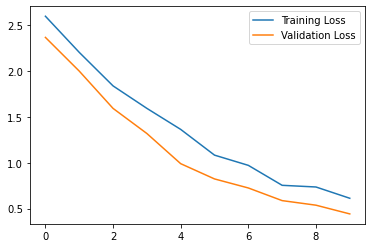

In [12]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


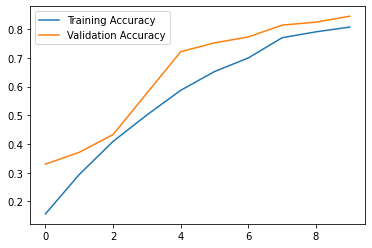

In [13]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [14]:

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 87%


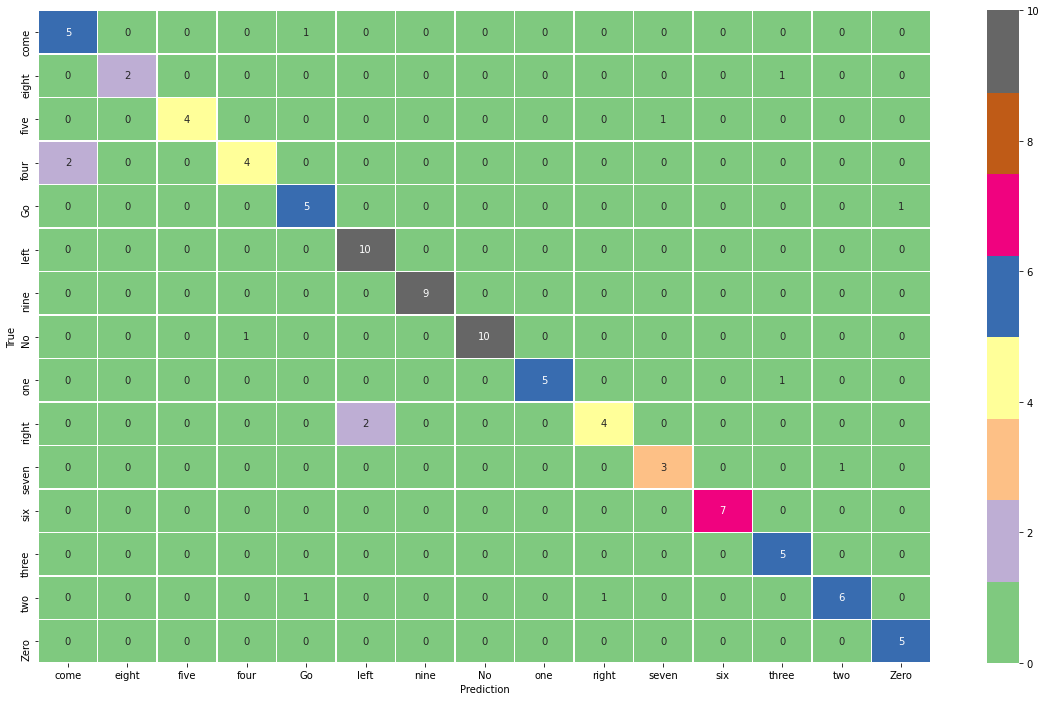

In [15]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(20, 12))

sns.heatmap(confusion_mtx, xticklabels=words, yticklabels=words, cmap='Accent',
            annot=True, fmt='g', linewidths=.5)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()


In [16]:
print(classification_report(y_true, y_pred, labels=np.unique(y_pred),  target_names= words))



              precision    recall  f1-score   support

        come       0.71      0.83      0.77         6
       eight       1.00      0.67      0.80         3
        five       1.00      0.80      0.89         5
        four       0.80      0.67      0.73         6
          Go       0.71      0.83      0.77         6
        left       0.83      1.00      0.91        10
        nine       1.00      1.00      1.00         9
          No       1.00      0.91      0.95        11
         one       1.00      0.83      0.91         6
       right       0.80      0.67      0.73         6
       seven       0.75      0.75      0.75         4
         six       1.00      1.00      1.00         7
       three       0.71      1.00      0.83         5
         two       0.86      0.75      0.80         8
        Zero       0.83      1.00      0.91         5

    accuracy                           0.87        97
   macro avg       0.87      0.85      0.85        97
weighted avg       0.88   

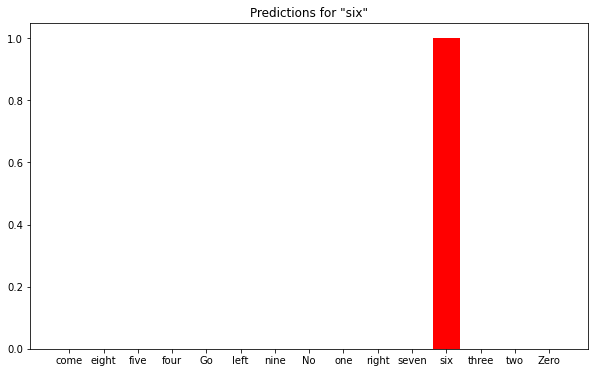

In [17]:
sample_file = myPath/'six/F03_B1_D6_M2.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(50):
  prediction = model(spectrogram)
  plt.figure(figsize=(10,6))
  plt.bar(words, tf.nn.softmax(prediction[0]), color = 'red')
  plt.title(f'Predictions for "{words[label[0]]}"')
  plt.show()
